LOAD DATA AND COMPUTE NORMALIZED SCATTERING COEFFICIENTS

In [33]:
import load_and_preprocessing_functions as lp
d, l = lp.get_pcg_data_and_labels(to_freq=1000, label_type='stai-3030')

In [1]:
import cv_and_classification_functions as cvc
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [35]:
import numpy as np 
from kymatio import Scattering1D
def remove_bad_features(J, Q, L, features, sr, keep_5060100hz=True):
    bad_freqs = [50, 60, 100, 120, 150, 180, 200, 240,250,300,350,360,400,420,450,480,500]
    if keep_5060100hz: bad_freqs = bad_freqs[3:]
    S = Scattering1D(J=J, shape=L, Q=Q, max_order=2)
    xi1s = S.meta()['xi'][:,0]*sr
    xi2s = S.meta()['xi'][:,1]*sr
    sigma1s = S.meta()['sigma'][:,0]*sr
    bad_feats = []
    new_feats = []
    new_feat_xi1s = []
    new_feat_xi2s = []
    for i in range(len(xi1s)):
        if i==0: bad_feats.append(i)
        for freq in bad_freqs:
            if xi1s[i] < freq+sigma1s[i]/2+7 and xi1s[i] > freq-sigma1s[i]/2-7:
                bad_feats.append(i)
    for i in range(features.shape[1]):
        if i not in bad_feats:
            new_feats.append(features[:,i].reshape(-1,1))
            new_feat_xi1s.append(xi1s[i])
            new_feat_xi2s.append(xi2s[i])
    return np.hstack(new_feats), new_feat_xi1s, new_feat_xi2s, xi1s, xi2s

In [36]:
J=4
Q=12
T=2**J
sec = 30
L = int(np.floor(sec*1000/2**J))*2**J
n_splits=10
x_train_scatter, y_train_scatter, x_val_scatter, y_val_scatter =\
                cvc.make_cross_val_scatter_data(J=J, Q=Q, L=L, data=d, labels=l, n_splits=n_splits, normalize=True, feature_reduction=False, sr=1000)
x_train_edit, x_val_edit = [], []
for i in range(n_splits):
    x_train_edit_i, new_xi1s, new_xi2s, xi1s, xi2s = remove_bad_features(J, Q, L, x_train_scatter[i], 1000, keep_5060100hz=False)
    x_val_edit_i, _, _, _, _= remove_bad_features(J, Q, L, x_val_scatter[i], 1000, keep_5060100hz=False)
    x_train_edit.append(x_train_edit_i)
    x_val_edit.append(x_val_edit_i)

DEFINE HYPERPARAMETER SPACES

In [37]:
xgb_stai_3030 = XGBClassifier(colsample_bytree=0.990046, 
                    eta=0.598764, 
                    gamma=4.999442, 
                    max_depth=15, 
                    min_child_weight=0, 
                    n_estimators=131, 
                    reg_alpha=5, 
                    reg_lambda=1.467703,
                    tree_method='hist')

xgb_stai_3520 = XGBClassifier(colsample_bytree=0.858025, 
                    eta=0.829672, 
                    gamma=2.005672, 
                    max_depth=7, 
                    min_child_weight=3, 
                    n_estimators=81, 
                    reg_alpha=52, 
                    reg_lambda=0.631727,
                    tree_method='hist')
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.neighbors import KNeighborsClassifier
knn_stai_3030 = KNeighborsClassifier(n_neighbors=18, p=1, n_jobs=-1)
knn_stai_3520 = KNeighborsClassifier(n_neighbors=4, p=2, n_jobs=-1)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


EVALUATION KNN + SAVE RESULTS

In [38]:
def final_eval_knn(clf, x_train, x_val, y_train, y_val, n_splits=10):
    y_ps = []
    y_ts = []
    rocauc_t = []
    rocauc_p = []
    for i in range(n_splits):
        print(i)
        scaler = StandardScaler()
        x_train_s = scaler.fit_transform(x_train[i])
        x_val_s = scaler.transform(x_val[i])
        clf.fit(x_train_s, y_train[i])
        y_true, y_pred = cvc.L_predictor(clf, L, 2**J, x_val_s, y_val[i])
        _, y_pred_proba = cvc.L_predictor_proba(clf, L, 2**J, x_val_s, y_val[i])
        rocauc_t.append(y_true)
        rocauc_p.append(y_pred_proba)
        y_ps += list(y_pred)
        y_ts += list(y_true)
    return y_ts, y_ps, rocauc_t, rocauc_p

y_true_knn, y_pred_knn, rocauc_t, rocauc_p = final_eval_knn(knn_stai_3030, x_train_edit, x_val_edit, y_train_scatter, y_val_scatter, n_splits=10)

0
1
2
3
4
5
6
7
8
9


In [39]:
import pandas as pd
final_eval_df = {'y_true' : y_true_knn, 'y_pred' : y_pred_knn, 'rocauc_p': rocauc_p, 'rocauc_t': rocauc_t}
pd.to_pickle(final_eval_df, 'results/final_eval/stai3030_knn.pkl')

EVALUATION XGB + SAVE RESULTS

In [40]:
import pandas as pd
def final_eval_xgb(clf, x_train, x_val, y_train, y_val, n_splits=10, xi1s=None, xi2s=None):
    y_ps = []
    y_ts = []
    rocauc_t = []
    rocauc_p = []
    frequency_s1s2 = []
    for e1, e2 in zip(xi1s, xi2s):
        if np.isnan(e2):
            frequency_s1s2.append(str('%.2f' % e1))
        else:
            frequency_s1s2.append(str('%.2f' % e1) + ', ' + str('%.2f' % e2))
    importances = pd.DataFrame(data={
    'Index': np.arange(x_train[0].shape[1]),
    'Importance': np.zeros(x_train[0].shape[1]),
    'frequency lambda' : frequency_s1s2,
    'frequency lambda 1' : new_xi1s,
    })
    for i in range(n_splits):
        print(i)
        scaler = StandardScaler()
        x_train_s = scaler.fit_transform(x_train[i])
        x_val_s = scaler.transform(x_val[i])
        clf.fit(x_train_s, y_train[i])
        y_true, y_pred = cvc.L_predictor(clf, L, 2**J, x_val_s, y_val[i])
        _, y_pred_proba = cvc.L_predictor_proba(clf, L, 2**J, x_val_s, y_val[i])
        importances['Importance'] += clf.feature_importances_
        rocauc_t.append(y_true)
        rocauc_p.append(y_pred_proba)
        y_ps += list(y_pred)
        y_ts += list(y_true)
    importances['Importance'] /= n_splits
    return y_ts, y_ps, importances, rocauc_t, rocauc_p

y_true_xgb, y_pred_xgb, importances, rocauc_t, rocauc_p = final_eval_xgb(xgb_stai_3030, x_train_edit, x_val_edit, y_train_scatter, y_val_scatter, n_splits=10, xi1s=new_xi1s, xi2s=new_xi2s)

0
1
2
3
4
5
6
7
8
9


In [41]:
final_eval_df = {'y_true' : y_true_xgb, 'y_pred' : y_pred_xgb, 'importances' : importances, 'rocauc_p': rocauc_p, 'rocauc_t': rocauc_t}
pd.to_pickle(final_eval_df, 'results/final_eval/stai3030_xgb.pkl')

LOAD RESULTS

In [2]:
import pandas as pd
knn_3520 = pd.read_pickle('results/final_eval/stai3520_knn.pkl')
knn_3030 = pd.read_pickle('results/final_eval/stai3030_knn.pkl')
xgb_3520 = pd.read_pickle('results/final_eval/stai3520_xgb.pkl')
xgb_3030 = pd.read_pickle('results/final_eval/stai3030_xgb.pkl')

PRINT CONFUSION MATRICES

In [3]:
%matplotlib qt
cvc.full_multiclass_report_sklearn(knn_3520['y_true'], knn_3520['y_pred'], classes=['low', 'high'], title=f'STAI-35-20, KNN Classifier')

Accuracy : 0.9077340569877883

Classification Report
              precision    recall  f1-score   support

         low    0.88050   0.98820   0.93124       932
        high    0.97430   0.76937   0.85979       542

    accuracy                        0.90773      1474
   macro avg    0.92740   0.87879   0.89552      1474
weighted avg    0.91499   0.90773   0.90497      1474

[[921  11]
 [125 417]]
specificity:  0.7693726937269373
sensitivity:  0.9881974248927039
AUC:  0.8787850593098206


In [4]:
cvc.full_multiclass_report_sklearn(knn_3030['y_true'], knn_3030['y_pred'], classes=['low', 'high'], title=f'STAI-30-30, KNN Classifier')
# \n 10-fold CV, L=30000, J=4, Q=12, 1000Hz\n n_neighbors=18, p=1 \n accuracy=0.8412, sensitivity=0.8846, specificity=0.7960

Accuracy : 0.8411764705882353

Classification Report
              precision    recall  f1-score   support

         low    0.81851   0.88462   0.85028       260
        high    0.86900   0.79600   0.83090       250

    accuracy                        0.84118       510
   macro avg    0.84375   0.84031   0.84059       510
weighted avg    0.84326   0.84118   0.84078       510

[[230  30]
 [ 51 199]]
specificity:  0.796
sensitivity:  0.8846153846153846
AUC:  0.8403076923076923


In [5]:
cvc.full_multiclass_report_sklearn(xgb_3520['y_true'], xgb_3520['y_pred'], classes=['low', 'high'], title='STAI-35-20, XGBoost Classifier')
#\n 10-fold CV, L=10000, J=3, Q=12, 1000Hz\n colsample_bytree=0.858025, eta=0.829672, gamma=2.005672, \n max_depth=7, min_child_weight=3, n_estimators=81, \n reg_alpha=52, reg_lambda=0.631727, tree_method=hist \n accuracy=0.9430, sensitivity=0.9796, specificity=0.8801

Accuracy : 0.9430122116689281

Classification Report
              precision    recall  f1-score   support

         low    0.93354   0.97961   0.95602       932
        high    0.96169   0.88007   0.91908       542

    accuracy                        0.94301      1474
   macro avg    0.94762   0.92984   0.93755      1474
weighted avg    0.94389   0.94301   0.94244      1474

[[913  19]
 [ 65 477]]
specificity:  0.8800738007380073
sensitivity:  0.9796137339055794
AUC:  0.9298437673217934


In [6]:
cvc.full_multiclass_report_sklearn(xgb_3030['y_true'], xgb_3030['y_pred'], classes=['low', 'high'], title=f'STAI-30-30, XGBoost Classifier')

#, L=30000, J=4, Q=12, 1000Hz\n colsample_bytree=0.990046, eta=0.598764, gamma=4.999442, \n max_depth=15, min_child_weight=0, n_estimators=131, \n reg_alpha=5, reg_lambda=1.467703, tree_method=hist \n accuracy=0.8510, sensitivity=0.9000, specificity=0.8000'


Accuracy : 0.8509803921568627

Classification Report
              precision    recall  f1-score   support

         low    0.82394   0.90000   0.86029       260
        high    0.88496   0.80000   0.84034       250

    accuracy                        0.85098       510
   macro avg    0.85445   0.85000   0.85032       510
weighted avg    0.85385   0.85098   0.85051       510

[[234  26]
 [ 50 200]]
specificity:  0.8
sensitivity:  0.9
AUC:  0.8500000000000001


PLOT FEATURE IMPORTANCE

In [7]:
importances_3030 = xgb_3030['importances']
importances_3520 = xgb_3520['importances']

In [8]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
importances = importances_3030.sort_values(by='frequency lambda 1', ascending=True)
plt.bar(x=importances['frequency lambda'], height=importances['Importance'])
plt.title('XGBoost Feature Importance, STAI-30-30', size=20)
plt.xticks([e for e in importances['frequency lambda']], rotation='vertical')
plt.xlabel(r'Wavelet Center Frequency $(\xi_{\lambda_1})$ or $(\xi_{\lambda_1}, \xi_{\lambda_2})$ Hz', size=15)
plt.ylabel('Importance', size=15)
plt.show()

In [9]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
importances = importances_3520.sort_values(by='frequency lambda 1', ascending=True)
plt.bar(x=importances['frequency lambda'], height=importances['Importance'])
plt.title('XGBoost Feature Importance, STAI-35-20', size=20)
plt.xticks([e for e in importances['frequency lambda']], rotation='vertical')
plt.xlabel(r'Wavelet Center Frequency $(\xi_{\lambda_1})$ or $(\xi_{\lambda_1}, \xi_{\lambda_2})$ Hz', size=15)
plt.ylabel('Importance', size=15)
plt.show()


PLOT ROC AUC

0.9708298850835327 0.06713747481781286


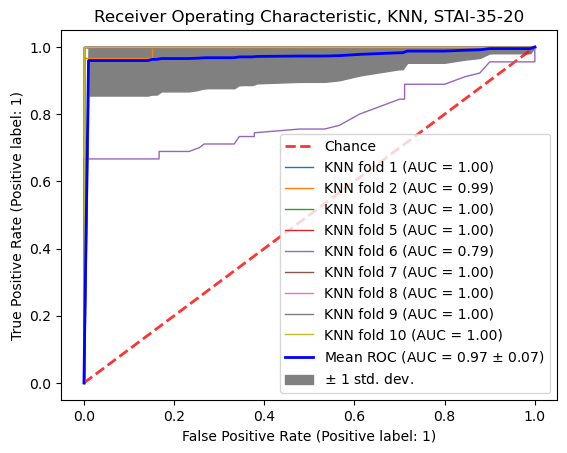

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i in range(n_splits):
    if i == 3: continue
    fpr, tpr, tresh = roc_curve(knn_3520['rocauc_t'][i], knn_3520['rocauc_p'][i])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    viz = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=f'KNN fold {i+1}', pos_label=1).plot(ax=ax, lw=1)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
print(mean_auc, std_auc)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic, KNN, STAI-35-20",
  )
ax.legend(loc="lower right")
plt.savefig("results/final_eval/rocauc_knn_3520.pdf")
plt.show()

0.9687125652333284 0.07427470416357837


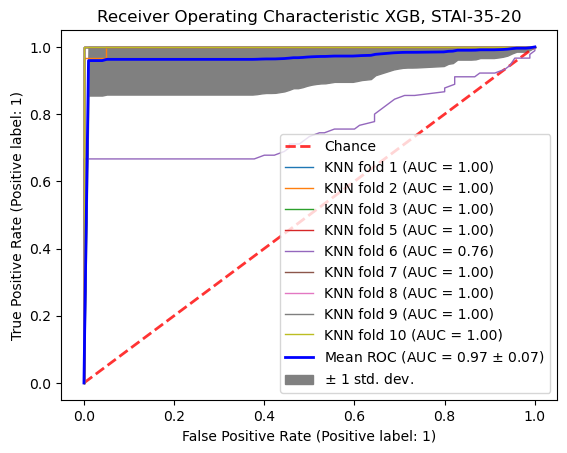

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
tprs = []
aucs = []
for i in range(n_splits):
    if i == 3: continue
    fpr, tpr, tresh = roc_curve(xgb_3520['rocauc_t'][i], xgb_3520['rocauc_p'][i])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    viz = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=f'KNN fold {i+1}', pos_label=1).plot(ax=ax, lw=1)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
print(mean_auc, std_auc)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic XGB, STAI-35-20",
  )
ax.legend(loc="lower right")
plt.savefig("results/final_eval/rocauc_xgb_3520.pdf")
plt.show()

0.7814898989898991 0.3132663563167931


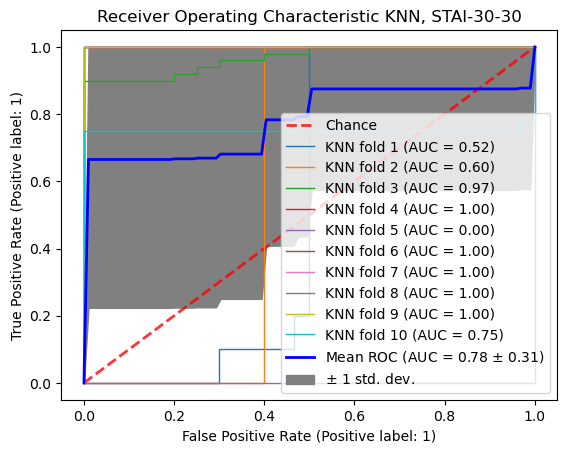

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
tprs = []
aucs = []
for i in range(n_splits):
    fpr, tpr, tresh = roc_curve(knn_3030['rocauc_t'][i], knn_3030['rocauc_p'][i])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    viz = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=f'KNN fold {i+1}', pos_label=1).plot(ax=ax, lw=1)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print(mean_auc, std_auc)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic KNN, STAI-30-30",
  )
ax.legend(loc="lower right")
plt.savefig("results/final_eval/rocauc_KNN_3030.pdf")
plt.show()

0.7907338026731966 0.3132663563167931


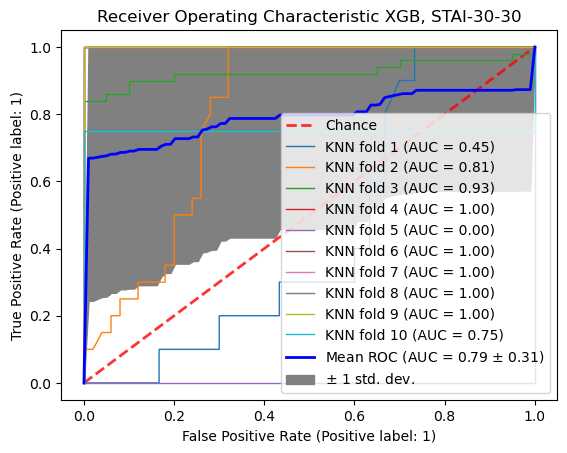

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
tprs = []
aucs = []
for i in range(n_splits):
    fpr, tpr, tresh = roc_curve(xgb_3030['rocauc_t'][i], xgb_3030['rocauc_p'][i])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    viz = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=f'KNN fold {i+1}', pos_label=1).plot(ax=ax, lw=1)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
print(mean_auc, std_auc)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic XGB, STAI-30-30",
  )
ax.legend(loc="lower right")
plt.savefig("results/final_eval/rocauc_xgb_3030.pdf")
plt.show()